# ML@AIMAS 2024 - Day 1 - Analiza exploratorie a datelor (EDA)

Florin Dumitrescu

În acest notebook vom analiza un set de date folosit pentru task-ul de segmentare a instanțelor de alimente din 
imagini. Imaginile au fost colectate în cadrul unui proiect de cercetare a laboratorului AIMAS cu ajutorul 
studenților de la Facultatea de Automatică și Calculatoare.

Restul notebook-ului este scris în limba engleză.

In [2]:
import json
from pathlib import Path
from typing import Any, List, Dict, Tuple

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import fractions
import seaborn as sns
import PIL.Image as Image 
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from skimage import color as skcolor

## Setting up the plotting style

We will be using `matplotlib` and `seaborn` plotting libraries for all the plots. The following code block sets up 
the plotting style for the notebook.

In [3]:
font = {'family' : 'Ubuntu',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
# %matplotlib ipympl

In [4]:
# Set display option to show all rows without truncation
pd.set_option('display.max_rows', None)

## Loading the dataset

We are using the following directory structure for our dataset:
```
dataset
├── images
│   ├── task0
│   │   ├── 0.jpg
│   │   ├── 1.jpg
│   │   └── ...
│   ├── task1
│   │   ├── 0.jpg
│   │   ├── 1.jpg
│   │   └── ...
│   └── ...
├── train.json
├── test.json
└── classes.txt
```
The `train.json` and `test.json` files are the annotations files for the train and test sets respectively. The 
`images` folder contains the images for each task in a separate folder (as per the annotation process) and the images are 
 referenced as such in the annotation files. The `classes.txt` file contains the list of classes in the dataset in 
 the order they appear in the annotation files, not in order of the category ID.

In [5]:
# Set up the paths
root_dir: Path = Path('data/intali')

image_root_dir: Path = root_dir / 'images'

train_ann_path = root_dir / 'train.json'
test_ann_path = root_dir / 'test.json'
classes_path = root_dir / 'classes.txt'

In [6]:
# Read the annotation files
with open(train_ann_path) as f:
    train_ann = json.load(f)

with open(test_ann_path) as f:
    test_ann = json.load(f)

## Basic information about the dataset

The annotations are in COCO format. In the following code block we will show the structure of the annotation files 
(without extra metadata such as `info` and `licenses`). 

In [7]:
# Show the structure of the annotation files
ann_structure = {
             "annotations": list(train_ann['annotations'][0].keys()),
             "images": list(train_ann['images'][0].keys()),
             "categories": list(train_ann['categories'][0].keys())}

print(json.dumps(ann_structure, indent=4))
del ann_structure

{
    "annotations": [
        "area",
        "bbox",
        "category_id",
        "id",
        "image_id",
        "iscrowd",
        "segmentation"
    ],
    "images": [
        "coco_url",
        "date_captured",
        "file_name",
        "flickr_url",
        "height",
        "id",
        "license",
        "width"
    ],
    "categories": [
        "id",
        "name",
        "supercategory"
    ]
}


The annotation of an object contains the following information:
- `id`: The unique ID of the object
- `image_id`: The ID of the image the object belongs to
- `category_id`: The ID of the category the object belongs to
- `bbox`: The bounding box of the object in the format `[x, y, width, height]`
- `segmentation`: The segmentation mask of the object (as list)
- `area`: The area of the object
- `iscrowd`: Whether the object is a crowd or not (not used in this dataset)

In [8]:
# Show the structure of the annotation of an object
print(json.dumps(train_ann['annotations'][0], indent=4))

{
    "area": 102574.0,
    "bbox": [
        439.1771382274892,
        288.4601896668173,
        274.0952129071338,
        476.2797248670213
    ],
    "category_id": 79,
    "id": 4,
    "image_id": 1,
    "iscrowd": 0,
    "segmentation": [
        [
            573.34765625,
            764.296875,
            587.4037208172304,
            764.7399145338386,
            606.9945997885443,
            763.3010364173024,
            634.3332840027506,
            757.4348410191124,
            662.0040170130815,
            745.0383526304831,
            687.2397255185024,
            729.874790940823,
            703.8421653247024,
            710.9480095617546,
            712.69679988801,
            691.2464476583991,
            713.272351134623,
            664.4169049315824,
            708.8782387325809,
            647.7812602457707,
            696.6367064488113,
            626.5522738802465,
            688.0366426292021,
            441.98848470133817,
            69

The annotations references the images by their ID. The image information contains the following information:
- `id`: The unique ID of the image
- `width`: The width of the image
- `height`: The height of the image
- `file_name`: The name of the image file
- `license`: The license of the image (not used in this dataset)
- `flickr_url`: The Flickr URL of the image (not used in this dataset)
- `coco_url`: The COCO URL of the image (not used in this dataset)
- `date_captured`: The date the image was captured (not used in this dataset)

In [9]:
def get_image_by_id(data: dict[str, Any], img_id: int) -> dict[str, Any]:
    """
    Get the image information by its ID
    
    :param data: annotations dictionary in COCO format
    :param img_id: ID of the image
    :return: image entry from the annotations dictionary
    """
    return [x for x in data['images'] if x['id'] == img_id][0]

In [10]:
# Get information about the image referenced by the first annotation
print(json.dumps(get_image_by_id(train_ann, train_ann['annotations'][0]['image_id']), indent=4))

{
    "coco_url": "",
    "date_captured": 0,
    "file_name": "task45/1.jpg",
    "flickr_url": "",
    "height": 900,
    "id": 1,
    "license": 0,
    "width": 1600
}


The annotation also references a category by its ID. The category information contains the following information:
- `id`: The unique ID of the category
- `name`: The name of the category
- `supercategory`: The supercategory of the category

In [11]:
def get_category_by_id(data: dict[str, Any], cat_id: int) -> dict[str, Any]:
    """
    Get the category information by its ID
    
    :param data: annotations dictionary in COCO format
    :param cat_id: ID of the category
    :return: category entry from the annotations dictionary
    """
    return [x for x in data['categories'] if x['id'] == cat_id][0]

def get_supercategories(data: dict[str, Any]) -> list[str]:
    """
    Get the list of supercategories in the dataset
    
    :param data: annotations dictionary in COCO format
    :return: list of supercategories
    """
    return list(set([x['supercategory'] for x in data['categories']]))

def get_categories(data: dict[str, Any]) -> list[str]:
    """
    Get the list of categories in the dataset
    
    :param data: annotations dictionary in COCO format
    :return: list of categories
    """
    return list(set([x['name'] for x in data['categories']]))

def get_categories_by_supercategory(data: dict[str, Any], supercategory: str) -> list[str]:
    """
    Get the list of categories in the dataset belonging to a supercategory
    
    :param data: annotations dictionary in COCO format
    :param supercategory: supercategory to filter by
    :return: list of categories
    """
    return list(set([x['name'] for x in data['categories'] if x['supercategory'] == supercategory]))

def get_supercategory_category_mapping(data: dict[str, Any]) -> dict[str, list[str]]:
    """
    Get a mapping between the supercategories and the categories belonging to them
    
    :param data: annotations dictionary in COCO format
    :return: dictionary of supercategory to list of categories
    """
    return {x: get_categories_by_supercategory(data, x) for x in get_supercategories(data)}

In [12]:
# Get information about the category referenced by the first annotation
print(json.dumps(get_category_by_id(train_ann, train_ann['annotations'][0]['category_id']), indent=4))

{
    "id": 79,
    "name": "Fruit Jam",
    "supercategory": "Sweets"
}


In total, we have defined 165 food categories, grouped in 10 supercategories, with a final supercategory `Others` 
that contains all the objects that could not be included in any of the existing supercategories and which were 
labeled as `Other` (category) during the annotation process.

In [13]:
print(f'This dataset contains {len(get_categories(train_ann))} '
      f'categories grouped in {len(get_supercategories(train_ann))} supercategories\n')
print('Supercategories: ')

# Get the list of supercategories and print them on separate lines
for supercat in get_supercategories(train_ann):
    print(f'\t- {supercat}')

This dataset contains 166 categories grouped in 11 supercategories

Supercategories: 
	- Meat and Seafood
	- Half-cooked meals
	- Canned Foods
	- Sweets
	- Fruits
	- Drinks
	- Eggs and Dairy
	- Cereal based products
	- Others
	- Spices, Flavourings, Sauces & cooking/baking aids
	- Vegetables


In [14]:
def plot_categories_per_supercategory(data: dict[str, Any]) -> None:
    """
    Plot the number of categories per supercategory
    
    :param data: annotations dictionary in COCO format
    """
    # Get the list of supercategories and the list of their categories
    mapping = get_supercategory_category_mapping(data)

    # Get number of categories per supercategory
    mapping = {k: len(v) for k, v in mapping.items()}
    
    # Sort the mapping by number of categories in descending order
    mapping = {k: v for k, v in sorted(mapping.items(), key=lambda item: item[1], reverse=True)}
    
    # Plot the data
    plt.figure(figsize=(15, 10))
    plt.xlabel('Supercategory')
    plt.ylabel('Number of categories')
    plt.title('Number of categories per supercategory')
    ax = sns.barplot(x=list(mapping.values()), y=list(mapping.keys()), color='tab:orange')
    plt.bar_label(ax.containers[0])
    plt.grid(visible=True, axis='y')
    plt.show()
    plt.close()

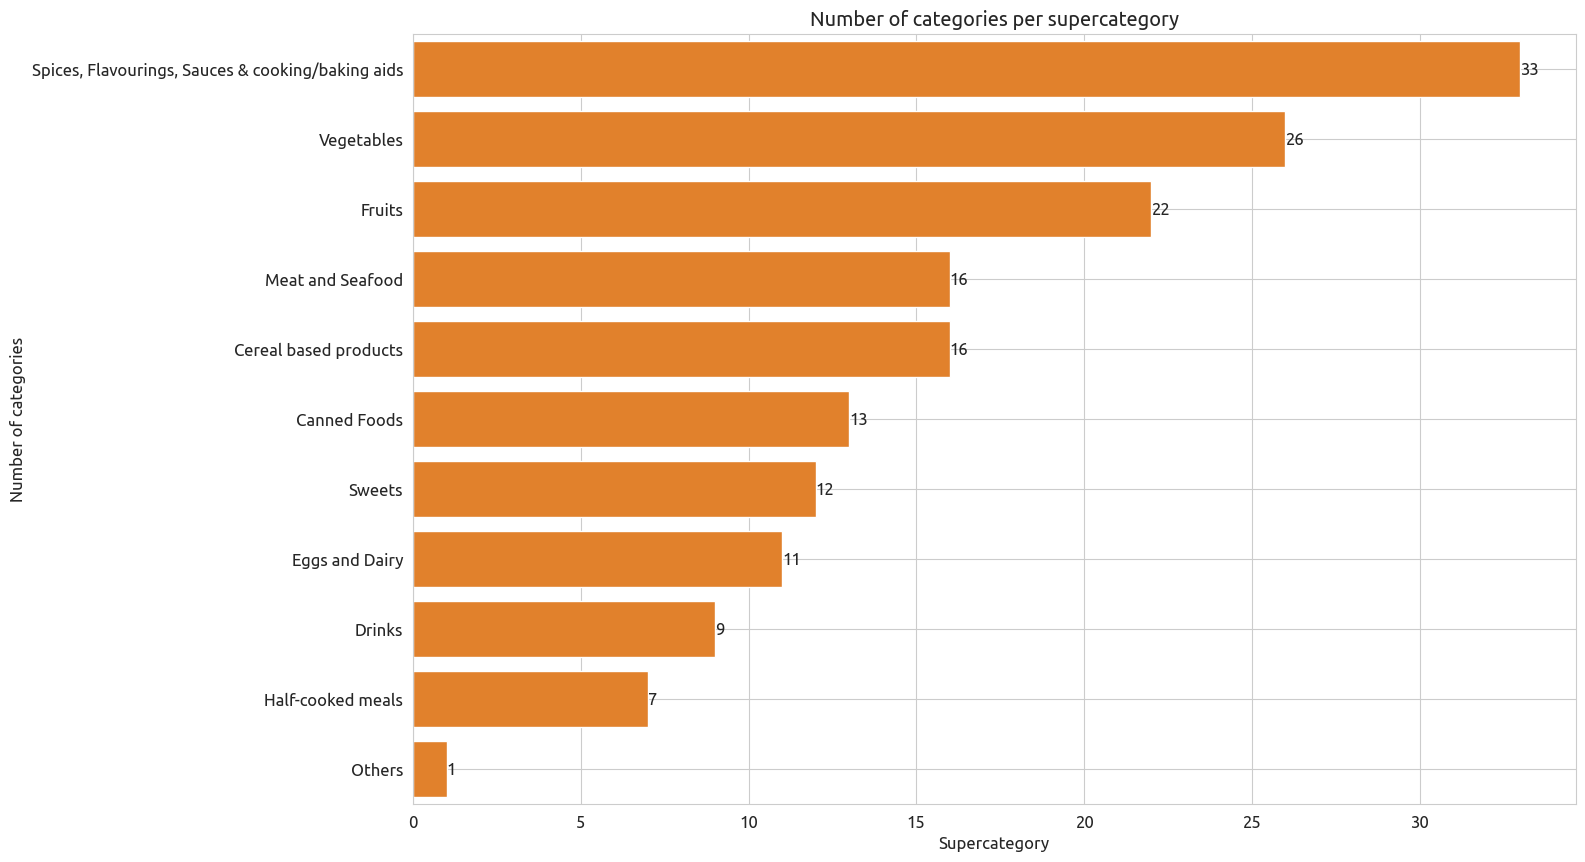

In [15]:
# Plot the number of categories per supercategory
plot_categories_per_supercategory(train_ann)

In [16]:
# Print the complete list of categories, grouped by supercategory
supercategory_category_map: Dict[str, List[str]] = get_supercategory_category_mapping(train_ann)

for supercat in supercategory_category_map.keys():
    print(f'{supercat} ({len(supercategory_category_map[supercat])}):')
    for cat in supercategory_category_map[supercat]:
        print(f'\t- {cat}')
    print()

Meat and Seafood (16):
	- Prosciutto
	- Chicken Thighs
	- Mincemeat
	- Meat
	- Beef
	- Liver
	- Salami
	- Whole Chicken
	- Pork Deli
	- Chicken Breast
	- Bacon
	- Smoked Salmon
	- Pork
	- Kaiser
	- Fish
	- Sausage

Half-cooked meals (7):
	- Frozen Pie
	- Frozen Pie Dough
	- Frozen Green Peas
	- Frozen Green Beans
	- Frozen French Fries
	- Frozen Mixed Vegetables
	- Frozen Pizza

Canned Foods (13):
	- Canned Beans
	- Pickled Tomatoes
	- Canned Fruit
	- Canned Corn
	- Canned Mushrooms
	- Pickled Hot Peppers
	- Canned Tomatoes
	- Canned Fish
	- Capers
	- Pate
	- Canned Meat
	- Canned Baby Carrots
	- Pickled Cucumbers

Sweets (12):
	- Wafers
	- Ladyfingers
	- Peanut Butter
	- Chocolate
	- Pudding
	- Fruit Jam
	- Candies
	- Sponge Cake
	- Biscuits
	- Honey
	- Gummies
	- Ice-Cream

Fruits (22):
	- Kiwi
	- Raspberry
	- Coconut
	- Hazelnuts
	- Orange
	- Strawberry
	- Pineapple
	- Fruits
	- Lemon
	- Apple
	- Pomegranate
	- Peanuts
	- Walnuts
	- Blueberries
	- Sweetie
	- Avocado
	- Pear
	- Almon

## Dataset images statistics

In this section we will explore how many images we have in the dataset, what resolution the images have and what are 
the most common aspect ratios. 

In [17]:
def show_basic_image_info(data: dict[str, Any]) -> None:
    """
    Show basic information about the images in the dataset
    
    :param data: annotations dictionary in COCO format
    """
    # Number of images in the dataset
    n_images = len(data['images'])
    
    # Height and width for each image in the dataset
    heights = np.array([x['height'] for x in data['images']])
    widths = np.array([x['width'] for x in data['images']])
    
    # Aspect ratios for the images in the dataset
    aspect_ratios = widths / heights
    
    print(f'Number of images: {n_images}\n')
    
    print(f'Height: '
          f'\n\t- Min: {np.min(heights)}'
          f'\n\t- Max: {np.max(heights)}'
          f'\n\t- Average: {np.mean(heights)}'
          f'\n\t- Median: {np.median(heights)}')
    
    print(f'Width: '
            f'\n\t- Min: {np.min(widths)}'
            f'\n\t- Max: {np.max(widths)}'
            f'\n\t- Average: {np.mean(widths)}'
            f'\n\t- Median: {np.median(widths)}\n')
    
    # Sort the images in ascending order by area
    sort_idx = (widths * heights).argsort()
    
    print(f'Smallest image resolution: {widths[sort_idx[0]]}x{heights[sort_idx[0]]}')
    print(f'Largest image resolution: {widths[sort_idx[-1]]}x{heights[sort_idx[-1]]}')
    print(f'Median image resolution: {widths[sort_idx[len(sort_idx) // 2]]}x{heights[sort_idx[len(sort_idx) // 2]]}\n')
    
    print(f'Aspect ratio: '
          f'\n\t- Min: {np.around(np.min(aspect_ratios), 2)} '
            f'or {fractions.Fraction(np.min(aspect_ratios)).limit_denominator(10)}'
          f'\n\t- Max: {np.around(np.max(aspect_ratios), 2)} '
            f'or {fractions.Fraction(np.max(aspect_ratios)).limit_denominator(10)}'
          f'\n\t- Median: {np.around(np.median(aspect_ratios), 2)} '
            f'or {fractions.Fraction(np.median(aspect_ratios)).limit_denominator(10)}\n')

In [18]:
# Get some basic information about the images in the train set
show_basic_image_info(train_ann)

Number of images: 3024

Height: 
	- Min: 720
	- Max: 4032
	- Average: 2246.530753968254
	- Median: 2268.0
Width: 
	- Min: 1280
	- Max: 5664
	- Average: 3588.681216931217
	- Median: 4032.0

Smallest image resolution: 1280x720
Largest image resolution: 4608x3456
Median image resolution: 4032x2268

Aspect ratio: 
	- Min: 0.56 or 5/9
	- Max: 2.17 or 13/6
	- Median: 1.78 or 16/9



In [19]:
# Get some basic information about the images in the test set
show_basic_image_info(test_ann)

Number of images: 953

Height: 
	- Min: 720
	- Max: 4032
	- Average: 2214.011542497377
	- Median: 2268.0
Width: 
	- Min: 1280
	- Max: 5664
	- Average: 3553.5603357817417
	- Median: 4032.0

Smallest image resolution: 1280x720
Largest image resolution: 4608x3456
Median image resolution: 4032x2268

Aspect ratio: 
	- Min: 0.49 or 1/2
	- Max: 2.17 or 13/6
	- Median: 1.78 or 16/9



As you can see, our image resolutions range from 1280x720 up to 3840x2160 and the aspect ratios range from 
`0.49` to `2.17`, with the most common one being `1.78` (16:9) for both the train and test set. For a better 
understanding of the aspect ratios, we will plot the distribution of aspect ratios as a KDE plot.

In [20]:
# Static variable for holding the location at which the peaks are in the KDE plot.
# The key is the aspect ratio and the value is the highest density at that point.
# Used for handling multiple function calls
kde_peaks: Dict[float, float] = {}

In [21]:
def get_sample_count_around_peak(data: dict[str, Any], 
                                 aspect_ratio: float, 
                                 tolerance: float = 0.05) -> int:
    """
    Get the number of images in the dataset with aspect ratios around the peak
    
    :param data: annotations dictionary in COCO format
    :param aspect_ratio: aspect ratio to check
    :param tolerance: tolerance around the peak
    :return: number of images with aspect ratios around the peak
    """
    # Height and width for each image in the dataset
    heights = np.array([x['height'] for x in data['images']])
    widths = np.array([x['width'] for x in data['images']])
    
    # Aspect ratios for the images in the dataset
    aspect_ratios = widths / heights
    
    # Get the indices of the images with aspect ratios around the peak
    indices = np.where(np.logical_and(aspect_ratios >= aspect_ratio - tolerance, 
                                      aspect_ratios <= aspect_ratio + tolerance))[0]
    
    return len(indices)

def plot_image_aspect_ratio_kde(data: dict[str, Any], 
                                label: str = "", 
                                fig: plt.Figure = None, 
                                show_plot: bool = False) -> plt.Figure | None:
    """
    Plot the distribution of the aspect ratios of the images in the dataset as a KDE plot
    
    :param data: annotations dictionary in COCO format
    :param label: label for the data
    :param fig: figure to plot on
    :param show_plot: whether to show the plot or not
    :return: figure with the plot or None if show_plot is True
    """
    # Height and width for each image in the dataset
    heights = np.array([x['height'] for x in data['images']])
    widths = np.array([x['width'] for x in data['images']])
    
    # Aspect ratios for the images in the dataset
    aspect_ratios = widths / heights

    # Calculate KDE
    kde = gaussian_kde(aspect_ratios)
    x_vals = np.linspace(0.1, np.max(aspect_ratios), 1000)  # Adjust range based on your aspect ratios
    kde_vals = kde(x_vals)
    
    # Find the peaks of the KDE plot
    peaks, _ = find_peaks(kde_vals)

    # Plot KDE
    if fig is None:
        fig = plt.figure(figsize=(8, 6))
        plt.xlabel('Aspect Ratio')
        plt.ylabel('Density')
        plt.title('Kernel Density Estimation of Image Aspect Ratios')        
        plt.grid(True)
    else:
        plt.figure(fig)
    plt.plot(x_vals, kde_vals, label=label)

    # Save the peaks in a static variable for handling multiple function calls
    for peak_idx in peaks:
        # Round the aspect ratio to 2 decimal places
        rounded_aspect_ratio = np.around(x_vals[peak_idx], 2)
        
        if rounded_aspect_ratio in kde_peaks.keys():
            kde_peaks[rounded_aspect_ratio] = max(kde_peaks[rounded_aspect_ratio], kde_vals[peak_idx])
        else:
            kde_peaks[rounded_aspect_ratio] = kde_vals[peak_idx]
    
    if show_plot:
        # Mark peaks using a vertical line and adjust text positions
        prev_y = 0  # Initialize previous y-coordinate
        prev_ar = 0  # Initialize previous aspect ratio
        
        for aspect_ratio, peak in sorted(kde_peaks.items(), key=lambda x: x[0]):
            plt.axvline(aspect_ratio, color='tab:gray', linestyle='--')
            
            # Check if current label overlaps with previous label
            if peak - prev_y < 0.15 and aspect_ratio - prev_ar < 0.1:  
                plt.text(aspect_ratio + 0.01, prev_y + 0.15, f'{aspect_ratio:.2f}')
                prev_y = prev_y + 0.15
            else:
                plt.text(aspect_ratio + 0.01, peak + 0.01, f'{aspect_ratio:.2f}')
                prev_y = peak
            prev_ar = aspect_ratio            
        
        # Clear the static variable
        kde_peaks.clear()
        
        # Show the plot
        plt.legend()
        plt.show()
        plt.close()
    else:
        plt.close(fig)
    return fig    

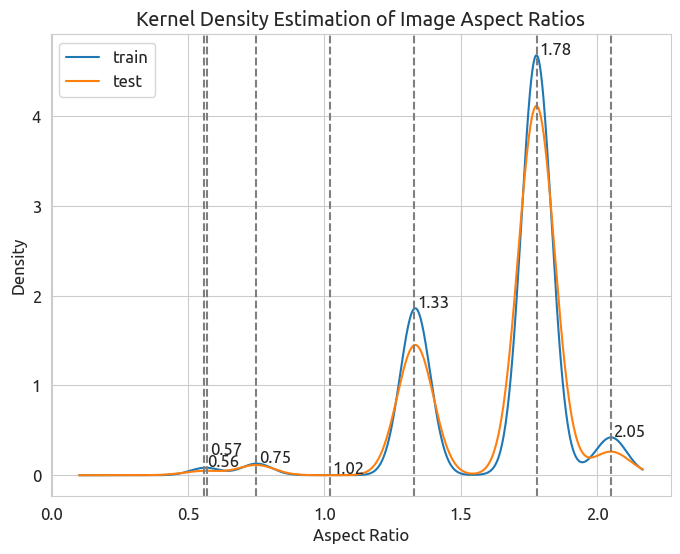

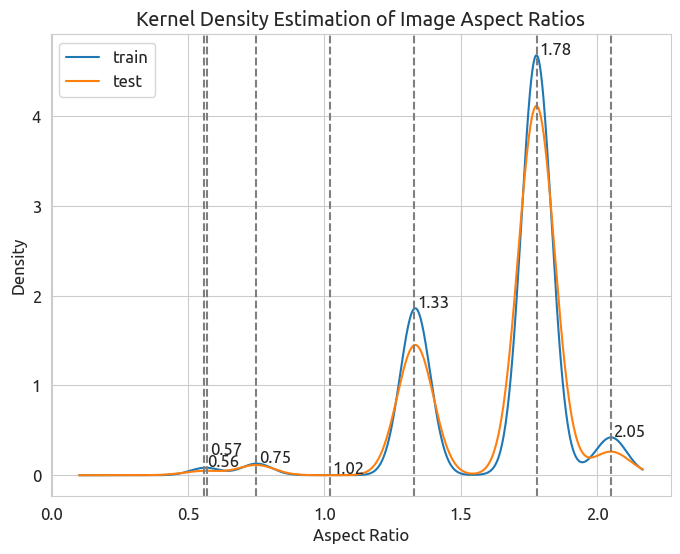

In [22]:
# Plot aspect ratios as KDE
aspect_ratio_plot = plot_image_aspect_ratio_kde(train_ann,
                                                label='train')
plot_image_aspect_ratio_kde(test_ann, 
                            label='test', 
                            fig=aspect_ratio_plot, 
                            show_plot=True)

Given the information we gained from the KDE plot, we now know that the most common aspect ratios are `1.78` (16:9), `1.33` (4:3), with some existing examples for `2.05` (~ 2:1), `0.56` (9:16) and `0.75` (3:4). Let's see how many images we have for each of these aspect ratios.

In [23]:
# Define the aspect ratios and labels
common_aspect_ratios = [(1.78, '16:9'), (1.33, '4:3'), (2.05, '2:1'), (0.75, '3:4'), (0.56, '9:16'), (1.02, '1:1')]

# Calculate the number of images for each aspect ratio in the train and test sets
train_counts = [get_sample_count_around_peak(train_ann, ar) for ar, label in common_aspect_ratios]
test_counts = [get_sample_count_around_peak(test_ann, ar) for ar, label in common_aspect_ratios]

# Create a DataFrame
df = pd.DataFrame({
    'Aspect Ratio': [label for ar, label in common_aspect_ratios],
    'Train Set': train_counts,
    'Test Set': test_counts
})

# Set the aspect ratio as the index
df.set_index('Aspect Ratio', inplace=True)

# Display the DataFrame
display(df)

# Clear variables
del common_aspect_ratios
del train_counts
del test_counts
del df

,Train Set,Test Set
Aspect Ratio,,
16:9,1958,652
4:3,778,230
2:1,187,43
3:4,54,18
9:16,35,7
1:1,1,0


## Distribution of objects across images

In this section we will explore how many instances we have in the dataset, what is the distribution of number of instances per image (how many images have 1 instance, 2 instances etc., allowing for repeating ingredients in the 
same image) and what is the distribution of unique ingredients per image (the same as before, but all repeating instances of the same ingredient will only be counted once). 

Let's start by looking at the total number of instances in the dataset and the number of instances per ingredient class.

In [24]:
def get_basic_instances_information(data: dict[str, Any]) -> None:
    """
    Get basic information about the instances in the dataset
    
    :param data: annotations dictionary in COCO format
    """
    # Number of instances in the dataset
    n_instances = len(data['annotations'])
    
    # Number of instances per category
    cat_ids = [x['category_id'] for x in data['annotations']]
    cat_ids, cat_counts = np.unique(cat_ids, return_counts=True)
    
    # Sort the counts in descending order
    sort_idx = cat_counts.argsort()[::-1]
    cat_ids = cat_ids[sort_idx]
    cat_counts = cat_counts[sort_idx]
    
    print(f'Total number of instances: {n_instances}\n')
    
    # Create a DataFrame for better presentation
    category_names = [get_category_by_id(data, cat_id)["name"] for cat_id in cat_ids]
    instances_df = pd.DataFrame({
        'Category': category_names,
        'Instance Count': cat_counts
    })
    
    # Display the DataFrame
    display(instances_df)

In [25]:
# Get basic information about the instances in the train set
get_basic_instances_information(train_ann)

Total number of instances: 8982



,Category,Instance Count
0,Eggs,664
1,Apple,403
2,Yogurt,326
3,Banana,291
4,Tomato,286
5,Milk,271
6,Orange,189
7,Chocolate,181
8,Canned Fish,171
9,Carrot,160


In [26]:
# Get basic information about the instances in the test set
get_basic_instances_information(test_ann)

Total number of instances: 2922



,Category,Instance Count
0,Eggs,181
1,Apple,117
2,Yogurt,108
3,Milk,90
4,Banana,80
5,Chocolate,71
6,Tomato,68
7,Carrot,65
8,Lemon,64
9,Orange,62


In [27]:
def plot_instances_per_image(data: dict[str, Any] | List[dict[str, Any]],
                             labels: str | List[str],
                             colors: str | List[str] = 'tab:blue',
                             count_unique: bool = False,
                             limit_instances: int = 0) -> None:
    """
    Plots the distribution of the number of instances per image
    
    :param data: annotations dictionary in COCO format. If a list of annotations is provided, 
                 the function will plot the distribution of the number of instances per image 
                 for each annotation in a separate subplot
    :param labels: labels for the data
    :param colors: colors for the data
    :param count_unique: if set to `True`, the function will count the number of unique instances 
                         per image instead of the total number of instances per image
    :param limit_instances: limit the number of instances per image to this value. 
                            Any image with more instances will be appended 
                            to the last bin
    """
    if isinstance(data, dict):
        data = [data]
        
    if isinstance(labels, str):
        labels = [labels]
        
    if isinstance(colors, str):
        colors = [colors]
        
    assert len(data) == len(labels), 'The number of annotations and labels must be the same'
    assert len(data) == len(colors), 'The number of annotations and colors must be the same'
    
    # Create a plot with n subplots, where n is the number of annotations. The subplots share the X-axis
    fig, ax = plt.subplots(len(data), 1, figsize=(15, 5 * len(data) + 1), sharey='row')

    if len(data) == 1:
        ax = [ax]

    for i, d in enumerate(data):
        # Number of instances per image
        img_ids = [x['image_id'] for x in d['annotations']]
        img_ids, img_counts = np.unique(img_ids, return_counts=True)
        
        if count_unique:
            # Get the number of unique instances per image
            img2nboxes = {}
            
            for ann in d['annotations']:
                img_id = ann['image_id']
                cat_id = ann['category_id']
                
                if img_id in img2nboxes.keys():
                    if cat_id not in img2nboxes[img_id]:
                        img2nboxes[img_id].append(cat_id)
                else:
                    img2nboxes[img_id] = [cat_id]
            
            img_counts = np.array([len(x) for x in img2nboxes.values()])
        
        # Sort the counts in descending order
        sort_idx = img_counts.argsort()[::-1]
        img_ids = img_ids[sort_idx]
        img_counts = img_counts[sort_idx]
        
        # Get the number of images for each instance count
        img_counts, instance_counts = np.unique(img_counts, return_counts=True)
        
        if limit_instances > 0:
            # Group all instances counts above the limit into the last bin
            instance_counts_concat = instance_counts[img_counts >= limit_instances].sum()
            instance_counts = instance_counts[img_counts < limit_instances]
            instance_counts = np.concatenate([instance_counts, [instance_counts_concat]])
            img_counts = img_counts[img_counts < limit_instances]    
            img_counts = np.concatenate([img_counts, [f'>{limit_instances}']])
        
        # Plot the data
        if i == 0:
            if count_unique:
                ax[i].set_title('Distribution of number of unique instances per image')
            else:
                ax[i].set_title('Distribution of number of instances per image')
        
        ax[i].set_xlabel('Number of instances')
        ax[i].set_ylabel('Number of images')
        bar_container = ax[i].bar(np.arange(len(instance_counts)), 
                                  instance_counts, 
                                  tick_label=img_counts, 
                                  label=labels[i], 
                                  color=colors[i])
        ax[i].bar_label(bar_container)
        ax[i].legend()
    plt.tight_layout()
    plt.show()
    plt.close()

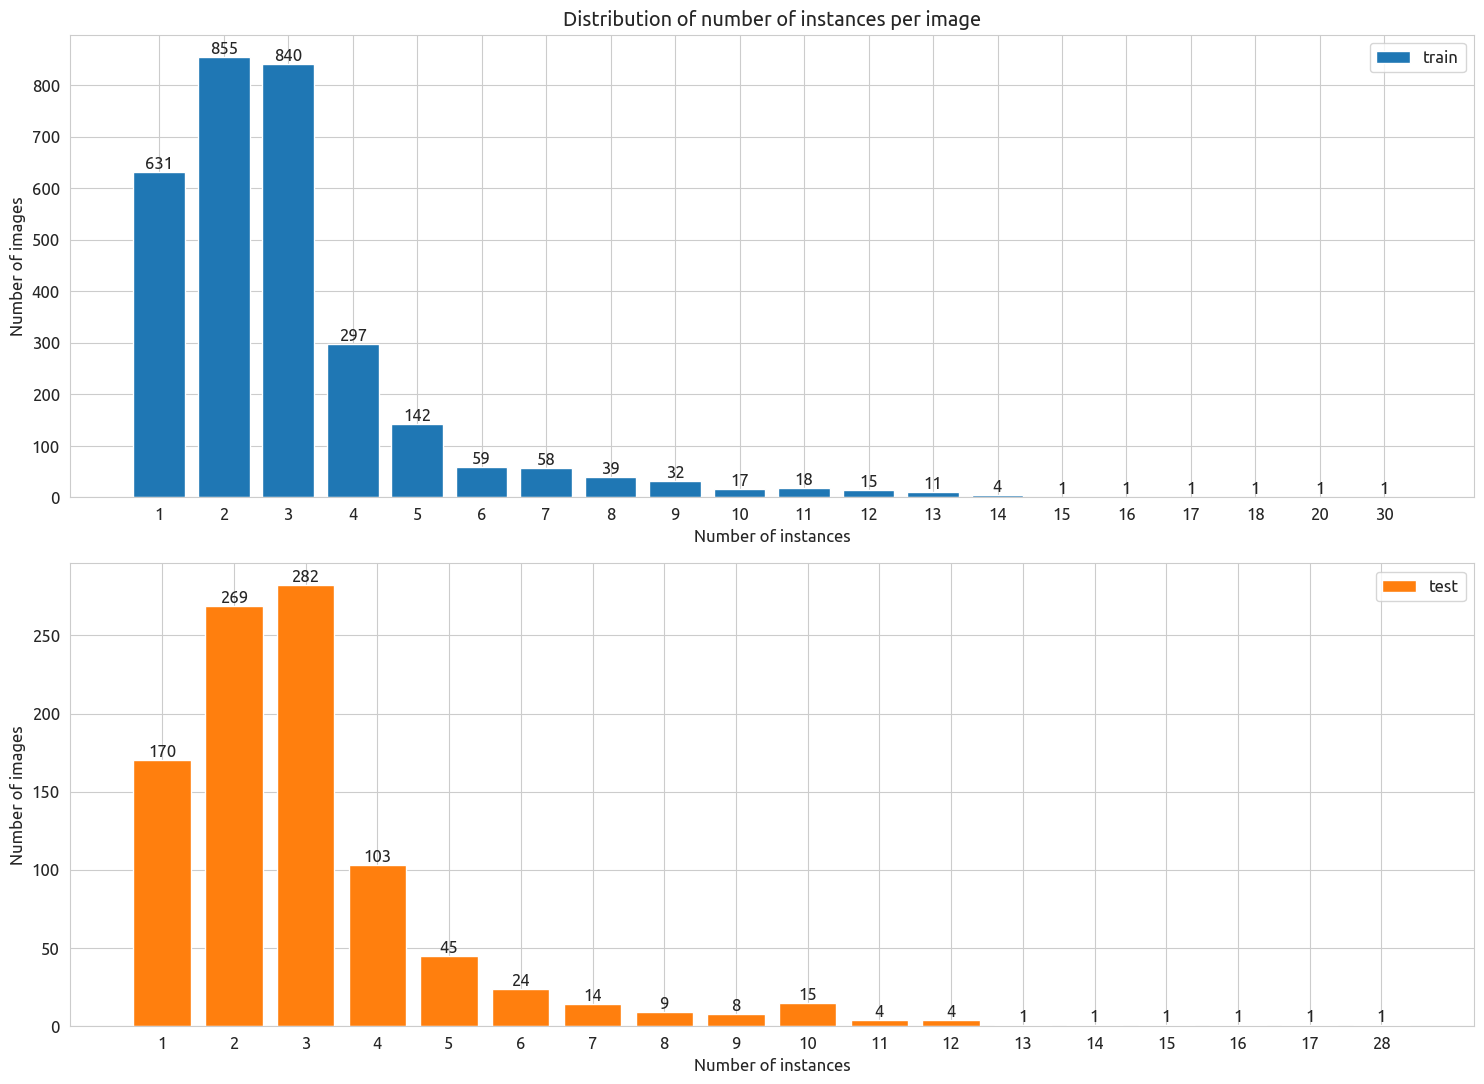

In [28]:
# Plot the distribution of the number of instances per image in both the train and test sets
plot_instances_per_image([train_ann, test_ann], ['train', 'test'], colors=['tab:blue', 'tab:orange'], limit_instances=0)

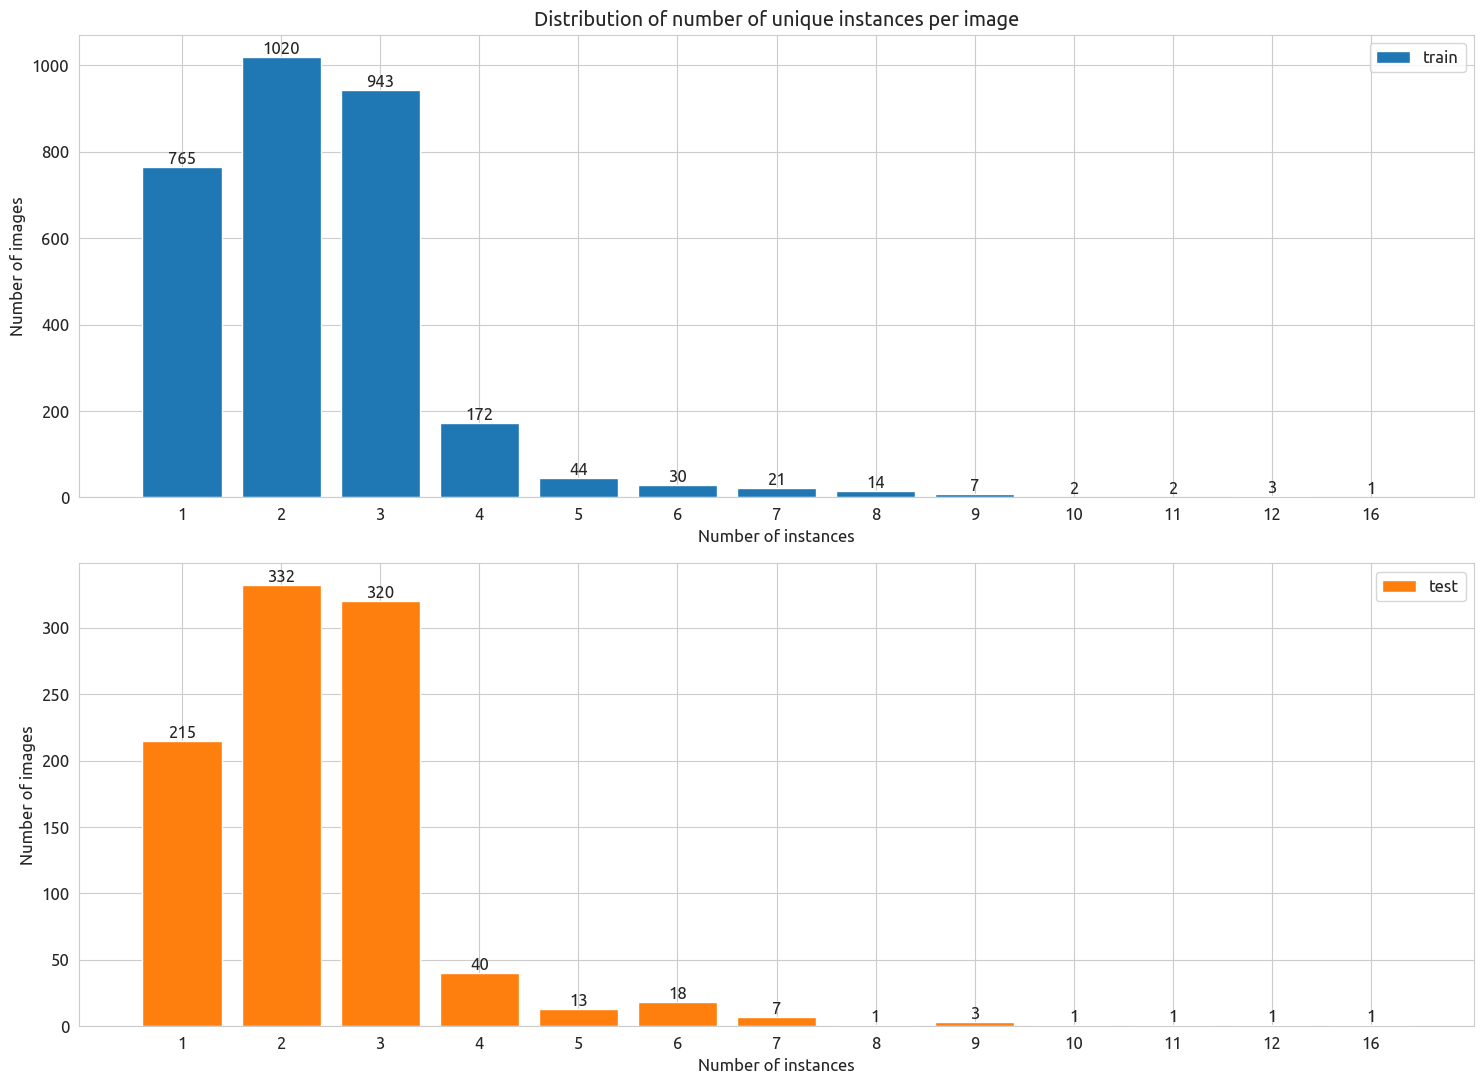

In [29]:
# Plot the distribution of the number of unique instances per image in both the train and test sets
plot_instances_per_image([train_ann, test_ann], ['train', 'test'], colors=['tab:blue', 'tab:orange'], count_unique=True, limit_instances=0)

## Object size statistics

In this section we will explore the size of the objects in the dataset. We will look at the distribution of object aspect ratios and the distribution of object sizes in terms of width and height, 
relative to the image size.

In [30]:
def plot_object_aspect_ratio_histogram(data: dict[str, Any], label: str = "", color='tab:blue') -> None:
    """
    Plot the distribution of the aspect ratios of the objects in the dataset
    
    :param data: annotations dictionary in COCO format
    :param label: label for the data
    """
    # Get the aspect ratios of the objects
    aspect_ratios = np.array([x['bbox'][2] / x['bbox'][3] for x in data['annotations']])
    
    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.hist(aspect_ratios, bins=50, alpha=0.7, label=label, color=color)
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Number of objects')
    plt.title('Distribution of Object Aspect Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

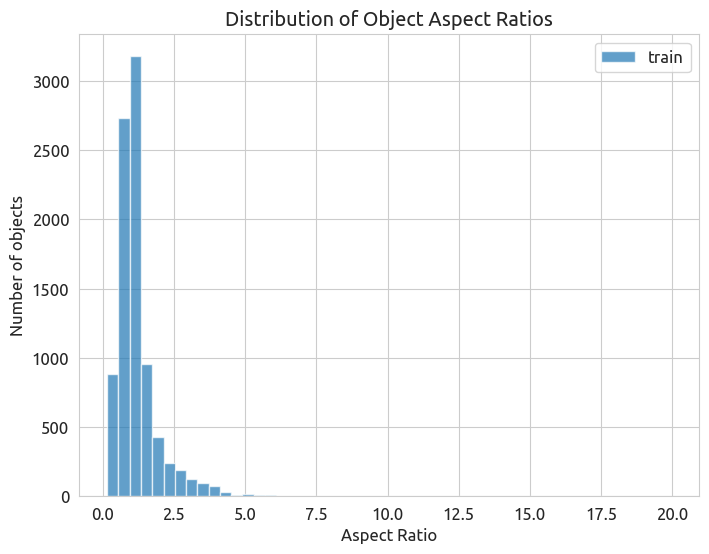

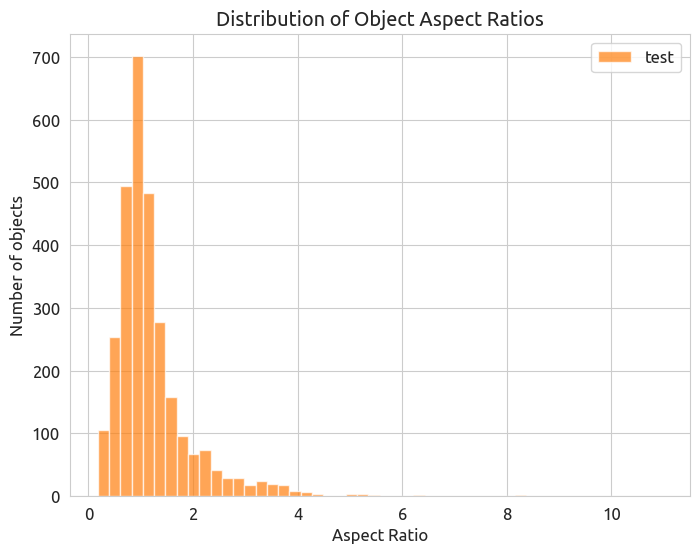

In [31]:
# Plot aspect ratios of the objects
plot_object_aspect_ratio_histogram(train_ann, label='train')
plot_object_aspect_ratio_histogram(test_ann, label='test', color='tab:orange')

In [32]:
def plot_object_size_contour(data: dict[str, Any], label: str = "", color: str = 'Blues') -> None:
    """
    Plot the distribution of the object sizes in the dataset
    
    :param data: annotations dictionary in COCO format
    :param label: label for the data
    :param color: color for the plot
    """
    # Get the object sizes
    heights = np.array([x['bbox'][3] for x in data['annotations']])
    widths = np.array([x['bbox'][2] for x in data['annotations']])
    
    # Calculate the relative object sizes
    rel_heights = heights / np.array([get_image_by_id(data, x['image_id'])['height'] for x in data['annotations']])
    rel_widths = widths / np.array([get_image_by_id(data, x['image_id'])['width'] for x in data['annotations']])
    
    # Plot the data
    plt.figure(figsize=(8, 6))
    sns.kdeplot(x=rel_widths, y=rel_heights, cmap=color, fill=True, label=label)
    plt.xlabel('Relative Width')
    plt.ylabel('Relative Height')
    plt.title('Distribution of Object Sizes')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


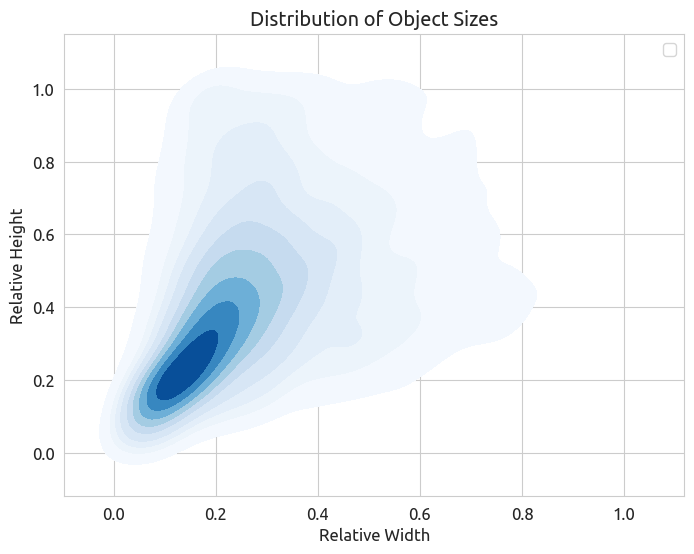

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


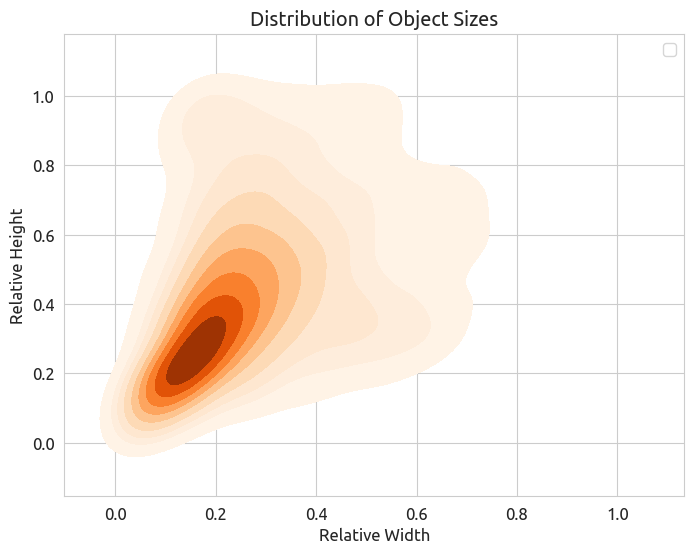

In [33]:
# Plot object sizes
plot_object_size_contour(train_ann, label='train')
plot_object_size_contour(test_ann, label='test', color='Oranges')

## Examples from the dataset

In this section we will show some image examples from the dataset. Let's start by creating helper functions to plot 
the images with annotations.

In [34]:
def generate_colors(n_colors: int) -> List[Tuple[int, int, int]]:
    """
    Generate a list of distinct colors
    
    :param n_colors: number of colors to generate
    :return: list of colors in RGB format. Each color is a tuple of 3 integers in the range [0, 255]
    """
    # Generate a list of colors
    colors = []

    for i in range(n_colors):
        # Convert the color from HSV to RGB
        c = skcolor.hsv2rgb(np.array([i / n_colors, 1, 1]))
        
        # Convert the color from [0, 1] to [0, 255] and append it to the list
        colors.append(tuple((c * 255).astype(np.uint8)))
    return colors

In [35]:
# Generate distinct colors for the categories
ann_colors = generate_colors(len(get_categories(train_ann)))

In [36]:
def get_contrastive_color(color: Tuple[int, int, int]) -> Tuple[int, int, int]:
    """
    Get a color that contrasts with the given color
    
    :param color: color to contrast with
    :return: contrasting color
    """
    # Calculate the perceptive luminance (https://en.wikipedia.org/wiki/Luma_(video))
    luminance = (0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]) / 255
    
    # Choose white or black depending on luminance
    if luminance > 0.5:
        return 0, 0, 0
    else:
        return 255, 255, 255
    
def draw_bbox(img: np.ndarray, 
                  bbox: np.ndarray, 
                  label: str, 
                  color: Tuple[int, int, int]) -> np.ndarray:
    # Draw bounding box
    bbox_int = bbox.astype(np.int32)
    left_top = (bbox_int[0], bbox_int[1])
    right_bottom = (bbox_int[2], bbox_int[3])
    cv2.rectangle(img, left_top, right_bottom, color, 2)

    font_face = cv2.FONT_HERSHEY_SIMPLEX
    
    # Set the font scale and thickness relative to the image size
    height, width = img.shape[:2]
    font_scale = max(height, width) / 2000 
    text_thickness = max(1, int(font_scale * 1.5))  # ensure the thickness is at least 1
    
    # Get the size of the text box
    ((text_width, text_height), _) = cv2.getTextSize(label, font_face, font_scale, text_thickness)

    # Calculate the position of the text, placing it inside the top left of the bounding box
    text_org = (bbox_int[0], bbox_int[1] + text_height + 10)

    # Calculate the coordinates of the rectangle around the label
    box_coords = (
        (text_org[0], text_org[1] + 10), 
        (text_org[0] + text_width, text_org[1] - text_height - 10)
    )
    
    # Draw a filled rectangle around the label
    cv2.rectangle(img, box_coords[0], box_coords[1], color, cv2.FILLED)
    
    # Choose a text color that contrasts with the background
    text_color = get_contrastive_color(color)

    cv2.putText(img=img, 
                text=label, 
                org=text_org, 
                fontFace=font_face, 
                fontScale=font_scale, 
                color=text_color, 
                thickness=text_thickness)
    
    return img

def show_annotated_image(data: dict[str, Any], img_id: int, colors: List[str], mask_opacity: float = 0.3) -> None:
    """
    Show an annotated image
    
    :param data: annotations dictionary in COCO format
    :param img_id: ID of the image to show
    :param colors: colors to use for the annotations in RGB format
    :param mask_opacity: opacity of the mask
    """
    # Get the image information
    img_info = get_image_by_id(data, img_id)
    
    # Get the image file name
    img_name = img_info['file_name']
    
    # Get the image width and height
    img_width = img_info['width']
    img_height = img_info['height']
    
    # Get the annotations for the image
    img_ann = [x for x in data['annotations'] if x['image_id'] == img_id]
    
    # Get the image
    img = np.asarray(Image.open(str(root_dir / 'images' / img_name)))
    
    # Clone the image for masks
    img_mask = img.copy()
    
    # Draw only the masks first
    for ann in img_ann:
        # Get the mask
        mask = np.array(ann['segmentation']).reshape(-1, 2)
        
        # Get color
        color = tuple(int(i) for i in colors[ann['category_id']])
        
        # Create the masked image
        img_mask = cv2.fillPoly(img_mask, [mask.astype(np.int32)], color)
        
        # Add mask contour
        img = cv2.polylines(img, [mask.astype(np.int32)], True, color, 2)
        
    # Blend the masked image with the original image
    img = cv2.addWeighted(img, 0.5, img_mask, 0.5, 0)
    
    # Draw the bounding boxes and labels
    for ann in img_ann:
        # Get the category information
        cat_info = get_category_by_id(data, ann['category_id'])

        # Get the category name
        cat_name = cat_info['name']        
        
        # Get the bounding box
        bbox = np.asarray(ann['bbox'])
        
        # Get color
        color = tuple(int(i) for i in colors[ann['category_id']])
        
        # Convert bounding box from (x, y, width, height) to (x1, y1, x2, y2)
        bbox[2] += bbox[0]
        bbox[3] += bbox[1]
        
        # Draw the bounding box and label
        img = draw_bbox(img, bbox, cat_name, color)
    
    display(Image.fromarray(img))

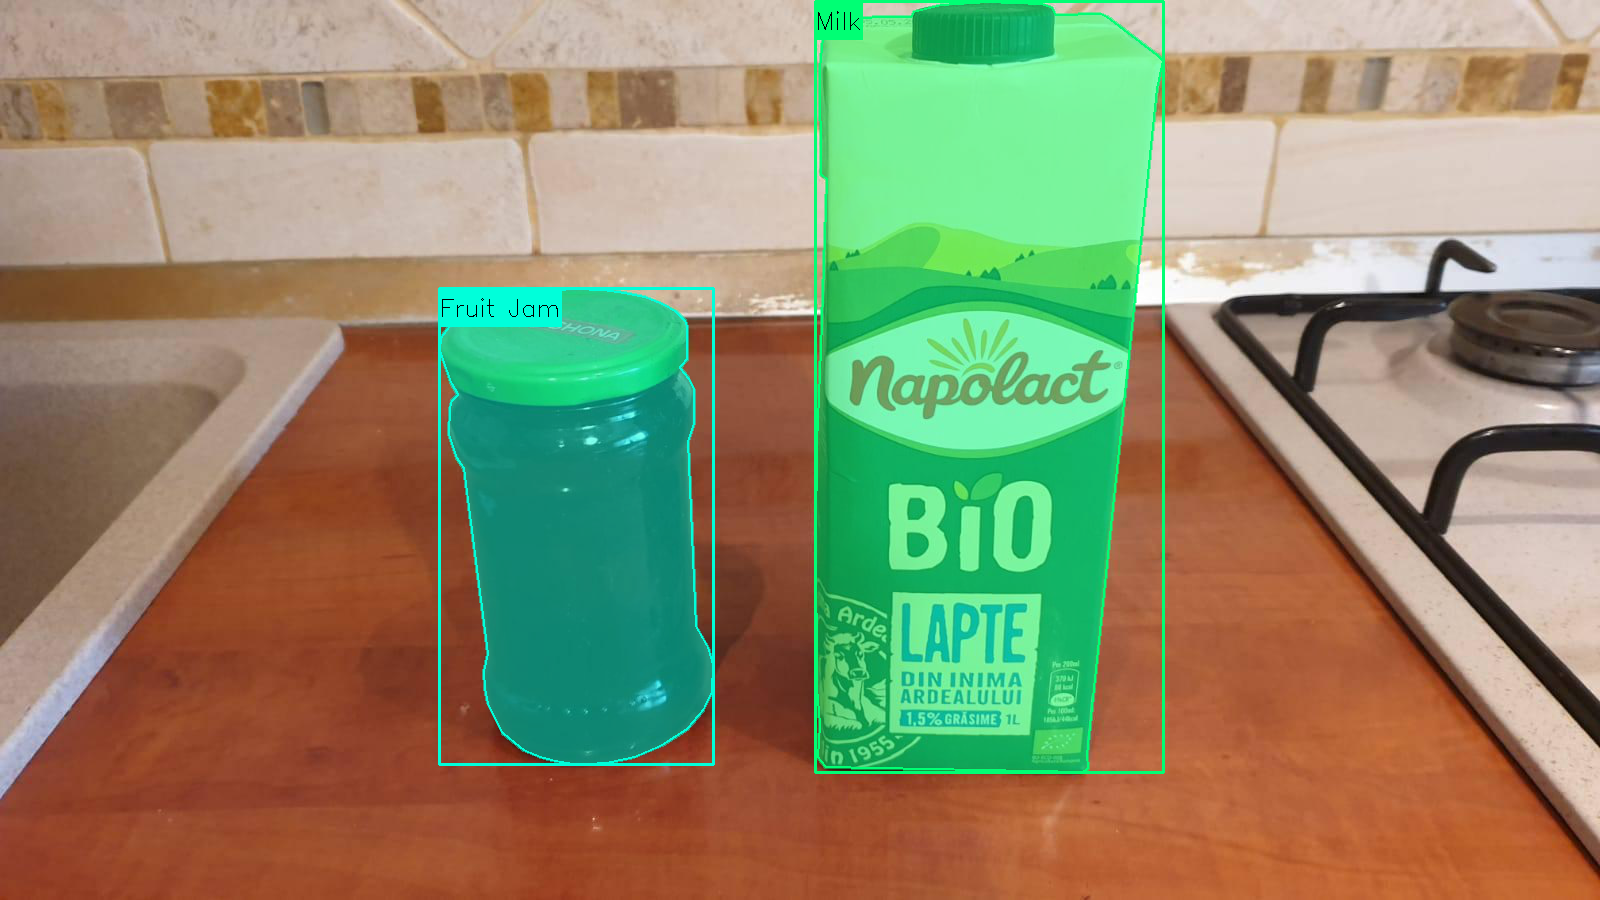

In [37]:
# Show an annotated image from the train set
show_annotated_image(train_ann, train_ann['annotations'][0]['image_id'], ann_colors)